# Answer to the Millennium interview question

## The problem
Predict electricity loads on a certain day in September 2020 using 60 years of station observations from many different stations in the region, and a model that estimates electricity loads from those observations (and other factors). 

For the purposes of the problem, I'll interpret the "electricity load" as the total demand for electricity over an entire day (in MWh; EIA predicts this quantity [here](https://www.eia.gov/realtime_grid/#/data/graphs?end=20190503T16&start=20190426T20&bas=000g&regions=0)). For example, if the demand in a certain area was 10 MWh for every hour in an entire day, then the "load" for that day would be 24*10 MWh = 240 MWh. This is the quantity I'll try to predict. 

## My response
Giving an accurate, deterministic forecast of the electricity load that far out is impossible because electricity loads are closely tied to weather and you can't predict the weather that far out. Therefore, I have to give a probabilistic forecast that includes an "expected" load, as well as reasonable upper/lower bounds for the load. 

Strategy for deriving the "expected" load and bounds: 
1. **Plug the weather observations (and other inputs) into the model.** This will provide estimates of what the electricity load would have been on every day in the past 60 years, if grid infrastructure had always been the same as it is now. 
2. **Then compile the daily electricity loads during the two weeks centered on that day in September, for every year in those 60 years of estimated loads** (do this separately for weekdays and weekends). This forms a distribution of what's reasonable to expect for that day in September 2020, if that day falls on either a weekend or weekday. I would use the two-week window so that the distribution is well-enough populated to get good estimates of the upper and lower bounds, but limit the window width to two weeks so that changes in climatologies are small over the window. 
3. **For my estimates of the lower bound, expected load, and upper bound, I would give the 5th percentile, median, and 95th percentile of that load distribution**. 

**If I wanted to take climate change into account**, I'd adjust the weather observations so that they're consistent with the expected climate state in 2020. For example, if I found that temperatures were consistently rising by 0.05 degC/yr in the region of interest, I'd add $0.05*(2020-yr)$ to the temperature observations in each year, $yr$. This would "adjust" the past weather observations to the climate state in 2020. I wouldn't adjust the relative humidity, cloud cover, or wind observations because changes in those are probably more difficult to pin down. 

## My implementation of the response

In [1]:
from MesoPy import Meso
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import requests
import os
import warnings

data_path = './data'
from global_vbls import api_key_synopticlabs
from global_fcns import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get weather observations
I pulled 17 years (2002-2019) of temperature and humidity measurements at Central Park from the [Synoptic Labs/Mesonet API](https://developers.synopticdata.com/). 

In [2]:
wx_obs, fname = retr_wxobs_synopticlabs(api_key_synopticlabs,data_path,station_id='knyc',
                                        st_time='199701010000',ed_time='201905010000',download_new=False)
obs_df = obs_dict2df(wx_obs)
obs_df = add_time_feats(obs_df)
obs_df.head()

,air_temp,relative_humidity,hour,day_of_week
date_time,,,,
2002-08-14 14:00:00-05:00,33.0,55.90,14,2
2002-08-14 15:00:00-05:00,33.0,55.90,15,2
2002-08-14 16:00:00-05:00,33.0,55.90,16,2
2002-08-14 17:00:00-05:00,31.0,48.96,17,2
2002-08-14 18:00:00-05:00,31.0,48.96,18,2


### Adjusting for climate change/urbanization

How quickly are temperatures rising in Central Park?

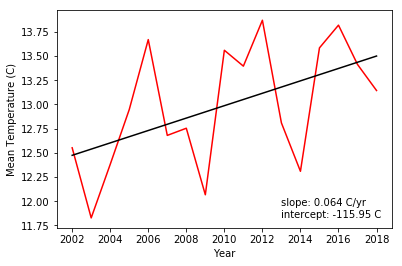

In [3]:
# Calculate mean temperatures from 2002-2018
obs_df['year'] = obs_df.index.year
annual_temps = obs_df.groupby('year')['air_temp'].agg('mean')
annual_temps = annual_temps[annual_temps.index<=2018]

# Run linear regression 
from scipy.stats import linregress
slope,intercept,_,_,_ = linregress(annual_temps.index.to_list(),annual_temps)

# Plot
fig = plt.figure()
plt.plot(annual_temps.index.to_list(),annual_temps,'r-')
plt.plot(annual_temps.index.to_list(),[slope*yr+intercept for yr in annual_temps.index.to_list()],'k-')
plt.xlabel('Year')
plt.ylabel('Mean Temperature (C)')
plt.text(2013,11.95,'slope: '+'%.3f'%slope+' C/yr')
plt.text(2013,11.825,'intercept: '+'%.2f'%intercept+' C')
plt.show()

The temperature rise seems linear with a slope of about 0.064 degC/yr. I'll correct for this by adding $0.05*(2020-yr)$ to temperature observations during each year.  

In [4]:
corr_obs_df = correct_for_climate_change(obs_df,slope)
obs_df = corr_obs_df.copy()

### Model for estimating electricity loads

Day of week, hour of day, temperature, and relative humidity go in, and hourly electricity demand (in MWh) comes out. The model takes the following form:   

$$LOAD = a(RH)*b(DOW)*c(HOD)*f(T),$$

where $a(RH)$ is a coefficient that depends on relative humidity, $b(DOW)$ is a coefficient that depends on the day of week, $c(HOD)$ is a coefficient that depends on the hour of day, and $f(T)$ is a value that depends on the temperature. These coefficients can be calculated from the relative humidity ($RH$), day of week ($DOW$), and hour of day $HOD$ according to the following equations: 

$$ a(RH) =  \left\{
\begin{array}{ll}
      1+0.05*\frac{(rh-50)}{50}, & RH\ge50 \\
      1, & RH<50 \\
\end{array} 
\right. $$ 

$$ b(DOW) =  \left\{
\begin{array}{ll}
      1.0, & DOW \in (M,T,W,R,F) \\
      0.9, & DOW \in (Sa,Su) \\
\end{array} 
\right. $$ 

$$c(HOD) = 1-0.125\cos[(HOD-4)*\pi/12]$$

$$ f(T) =  \left\{
\begin{array}{ll}
      4000-1000*\frac{T-15}{15}, & T<15 \\
      4000+8*(T-15)^2, & T\ge15 \\
\end{array} 
\right. $$ 

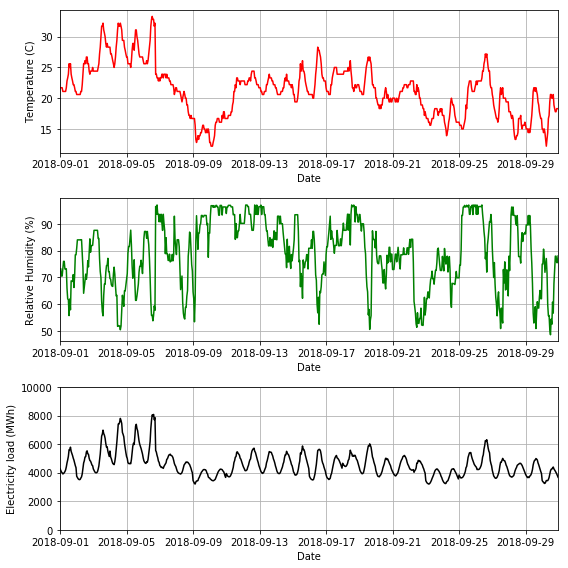

In [5]:
def load_estimator(row):
    RHc = lambda rh: 1+0.05*(rh-50)/50 if rh>=50 else 1
    DOWc = lambda dow: 1 if dow >=1 and dow<=5 else 0.9
    HODc = lambda hod: -0.125*np.cos((hod-4)*np.pi/12)+1
    temp2load = lambda T: (4000-(1000*(T-15)/15)) if T<15 else (4000+10*(T-15)**2)
    return RHc(row['relative_humidity'])*DOWc(row['day_of_week'])*HODc(row['hour'])*\
            temp2load(row['air_temp'])

obs_df['load'] = obs_df.apply(load_estimator,axis=1)
fig = plot_load_estimations(obs_df['20180901':'20180930'])

In the figure above, I've plotted time series of temperature at Central Park, relative humidity at Central Park, and model-estimated NYC electricity demand for 09/01/2018-09/31/2018. I think the load values seem reasonable. 

However, the model clearly isn't accurate; it's output is only intended to give me some ballpark load values that I can use to outline my forecasting process. If I needed an accurate load model, I'd build a statistical/machine learning model with real data from several stations over the past few years (as you said you've done). 


### Calculate daily electricity demand from hourly demand

In [6]:
daily_loads = total_load_by_day(obs_df)

### Calculate electricity forecasts for every day of the year in 2020

The top plot shows the anticipated weekday demands, while the bottom plot shows the anticipated weekend demands. The red lines represent the "expected" (median) demands, while the boundaries of the light gray shading represent the 5th and 95th percentiles, and the boundaries of the light gray shading represent the 1st and 99th percentiles. 

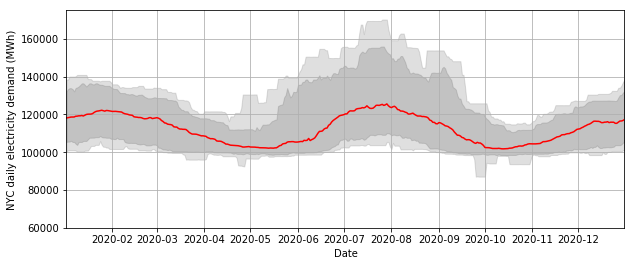

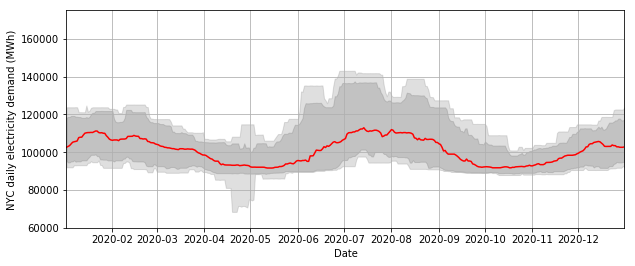

In [7]:
load_forecasts_week, load_forecasts_wknd = calc_daily_load_distributions(daily_loads,window_rad=7)

fig1 = plot_forecasts(load_forecasts_week)
fig2 = plot_forecasts(load_forecasts_wknd)

### Final load forecast

If someone asked me to forecast the electricity demand for September 2nd, 2020 (a Tuesday), I'd say that I expect the demand to be around 115,000 MWh (the median of the weekday distribution for that day), but say that the demand could fall anywhere between 100,000 MWh and 150,000 MWh (the approximate 1st and 99th percentiles). This forecast is incorrect, of course, because the electricity demands are calculated with a dummy model. 

In [8]:
load_forecasts_week.loc[date_to_dayofyear('20200902')]

0.01     99664.441547
0.05    101276.336939
0.50    115000.103250
0.95    144478.136066
0.99    153817.044388
Name: 246, dtype: float64